In [1]:
import pandas as pd
df = pd.read_csv("/mnt/appealing/sciCAR_cellline/scMVP_output/sciCAR_A549_DEG_tutorial.csv")
deg_1h = df[df['group'] == 'A549_1h']
deg_3h = df[df['group'] == 'A549_3h']

In [2]:
# find the significantly regulated genes
sig_deg_1h = deg_1h[(deg_1h['pvals_adj'] < 0.05) & (deg_1h['logfoldchanges'].abs() > 1)]
sig_deg_3h = deg_3h[(deg_3h['pvals_adj'] < 0.05) & (deg_3h['logfoldchanges'].abs() > 1)]

In [3]:
# get the specific and shared regulated genes
genes_1h = set(sig_deg_1h['names'])
genes_3h = set(sig_deg_3h['names'])

# 共有DEG
shared = genes_1h & genes_3h

# 特异性
specific_1h = genes_1h - genes_3h
specific_3h = genes_3h - genes_1h

In [4]:
print(len(shared))
print(len(specific_1h))
print(len(specific_3h))
# after 3h of treatment, more molecules involved

16
17
51


In [5]:
print(len(genes_1h))
print(len(genes_3h))

33
67


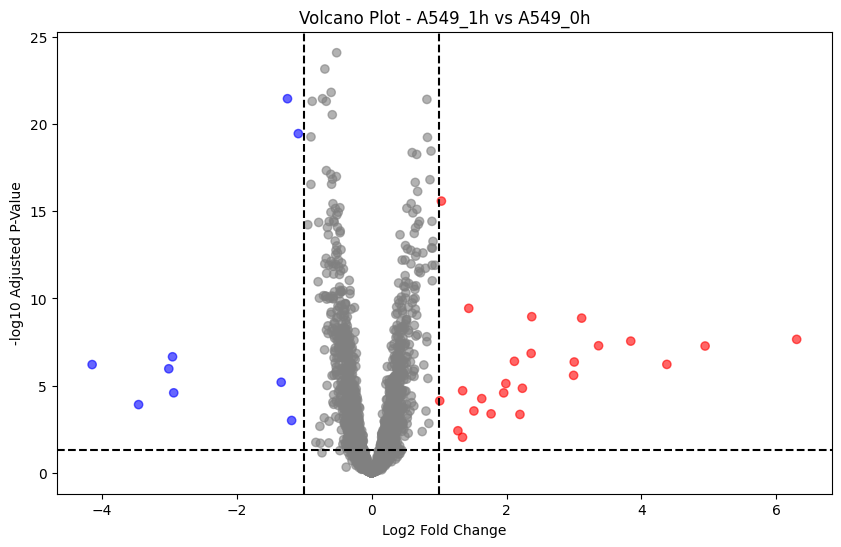

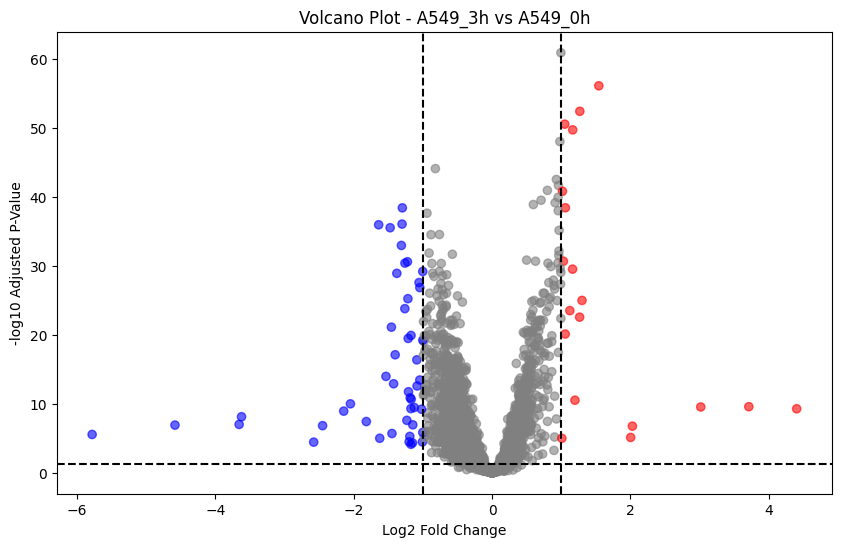

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_volcano(df_sub, title):
    df_sub["-log10(pvals_adj)"] = -np.log10(df_sub["pvals_adj"])
    pval_thresh = 0.05
    logfc_thresh = 1.0

    df_sub["color"] = "grey"
    df_sub.loc[(df_sub["pvals_adj"] < pval_thresh) & (df_sub["logfoldchanges"] > logfc_thresh), "color"] = "red"
    df_sub.loc[(df_sub["pvals_adj"] < pval_thresh) & (df_sub["logfoldchanges"] < -logfc_thresh), "color"] = "blue"

    plt.figure(figsize=(10, 6))
    plt.scatter(df_sub["logfoldchanges"], df_sub["-log10(pvals_adj)"], c=df_sub["color"], alpha=0.6)
    plt.axhline(-np.log10(pval_thresh), color='black', linestyle='--')
    plt.axvline(logfc_thresh, color='black', linestyle='--')
    plt.axvline(-logfc_thresh, color='black', linestyle='--')
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("-log10 Adjusted P-Value")
    plt.title(title)
    plt.show()

plot_volcano(deg_1h.copy(), "Volcano Plot - A549_1h vs A549_0h")
plot_volcano(deg_3h.copy(), "Volcano Plot - A549_3h vs A549_0h")

In [30]:
up_1h = set(gene for gene in
            deg_1h[(deg_1h['pvals_adj'] < 0.05) & (deg_1h['logfoldchanges'] > 1)]["names"]
            if not gene.startswith("ENSMU")
            )
print("There are " + str(len(up_1h)) + " genes significantly upregulated in A549 cells after 1h of DEX treatment.")

up_3h = set(gene for gene in
    deg_3h[(deg_3h['pvals_adj'] < 0.05) & (deg_3h['logfoldchanges'] > 1)]["names"]
           if not gene.startswith("ENSMU")
           )
print("There are " + str(len(up_3h)) + " genes significantly upregulated in A549 cells after 3h of DEX treatment.")

down_1h = set(gene for gene in
    deg_1h[(deg_1h['pvals_adj'] < 0.05) & (deg_1h['logfoldchanges'] < -1)]["names"]
             if not gene.startswith("ENSMU")
             )
print("There are " + str(len(down_1h)) + " genes significantly downregulated in A549 cells after 1h of DEX treatment.")
down_3h = set(gene for gene in
    deg_3h[(deg_3h['pvals_adj'] < 0.05) & (deg_3h['logfoldchanges'] < -1)]["names"]
             if not gene.startswith("ENSMU")
             )
print("There are " + str(len(down_3h)) + " genes significantly downregulated in A549 cells after 3h of DEX treatment.")


There are 14 genes significantly upregulated in A549 cells after 1h of DEX treatment.
There are 14 genes significantly upregulated in A549 cells after 3h of DEX treatment.
There are 6 genes significantly downregulated in A549 cells after 1h of DEX treatment.
There are 31 genes significantly downregulated in A549 cells after 3h of DEX treatment.


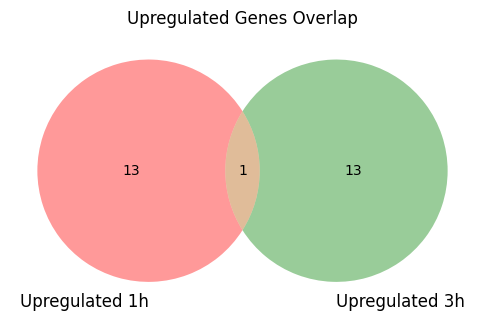

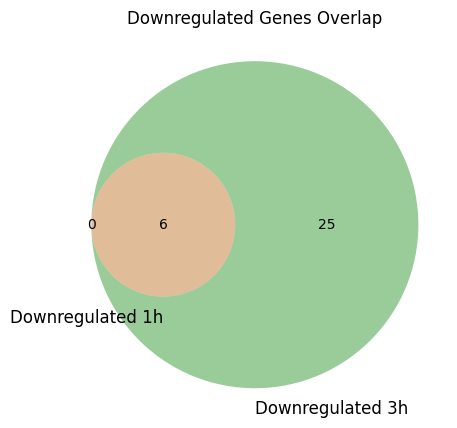

In [31]:
from matplotlib_venn import venn2

# finding the overlapping part
plt.figure(figsize=(6, 5))
venn2([up_1h, up_3h], set_labels=("Upregulated 1h", "Upregulated 3h"))
plt.title("Upregulated Genes Overlap")
plt.show()


plt.figure(figsize=(6, 5))
venn2([down_1h, down_3h], set_labels=("Downregulated 1h", "Downregulated 3h"))
plt.title("Downregulated Genes Overlap")
plt.show()

In [21]:
import os
target_dir = "/mnt/enrichment_output"
os.chdir(target_dir)
cwd = os.getcwd()

print("current directory：", cwd)

current directory： /mnt/enrichment_output


In [35]:
import gseapy as gp
from mygene import MyGeneInfo
import re
mg = MyGeneInfo()

def ensembl_to_symbol(ensembl_ids):
    clean_ids = [re.sub(r'\.\d+$', '', eid) for eid in ensembl_ids]
    query_result = mg.querymany(clean_ids, scopes='ensembl.gene', fields='symbol', species='human')
    return [r['symbol'] for r in query_result if 'symbol' in r]

up_1h_gene = ensembl_to_symbol(list(up_1h))
up_3h_gene = ensembl_to_symbol(list(up_3h))
down_1h_gene = ensembl_to_symbol(list(down_1h))
down_3h_gene = ensembl_to_symbol(list(down_3h))

def run_enrichr(gene_list, label):
    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets='KEGG_2021_Human',
        organism='Human',
        outdir=f'enrichr_{label}',
        cutoff=0.2
    )
    return enr

up_1h_only = list(set(up_1h_gene) - set(up_3h_gene))
up_3h_only = list(set(up_3h_gene) - set(up_1h_gene))
down_shared = list(set(down_1h_gene) & set(down_3h_gene))
down_3h_only = list(set(down_3h_gene) - set(down_1h_gene))

enr1 = run_enrichr(up_1h_only, "upregulated_in_1h_only")
enr2 = run_enrichr(up_3h_only, "upregulated_in_3h_only")
enr3 = run_enrichr(down_shared, "downregulated_in_both")
enr4 = run_enrichr(down_3h_only, "downregulated_in_3h_only")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found no hit:	['ENSG00000260411', 'ENSG00000241280']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found no hit:	['ENSG00000229702']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
3 input query terms found no hit:	['ENSG00000269990', 'ENSG00000241280', 'ENSG00000229702']


In [36]:
# 查看 top 富集条目
print(enr1.results.head())
print(enr2.results.head())
print(enr3.results.head())
print(enr4.results.head())

          Gene_set                                             Term Overlap   
0  KEGG_2021_Human                                 ABC transporters    1/45  \
1  KEGG_2021_Human                                Viral myocarditis    1/60   
2  KEGG_2021_Human  Arrhythmogenic right ventricular cardiomyopathy    1/77   
3  KEGG_2021_Human                         ECM-receptor interaction    1/88   
4  KEGG_2021_Human                      Hypertrophic cardiomyopathy    1/90   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio   
0  0.020073          0.082158            0                     0   56.667614  \
1  0.026683          0.082158            0                     0   42.228814   
2  0.034128          0.082158            0                     0   32.754934   
3  0.038918          0.082158            0                     0   28.597701   
4  0.039786          0.082158            0                     0   27.952247   

   Combined Score   Genes  
0      221.47987

<Axes: title={'center': '3h Downregulated'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

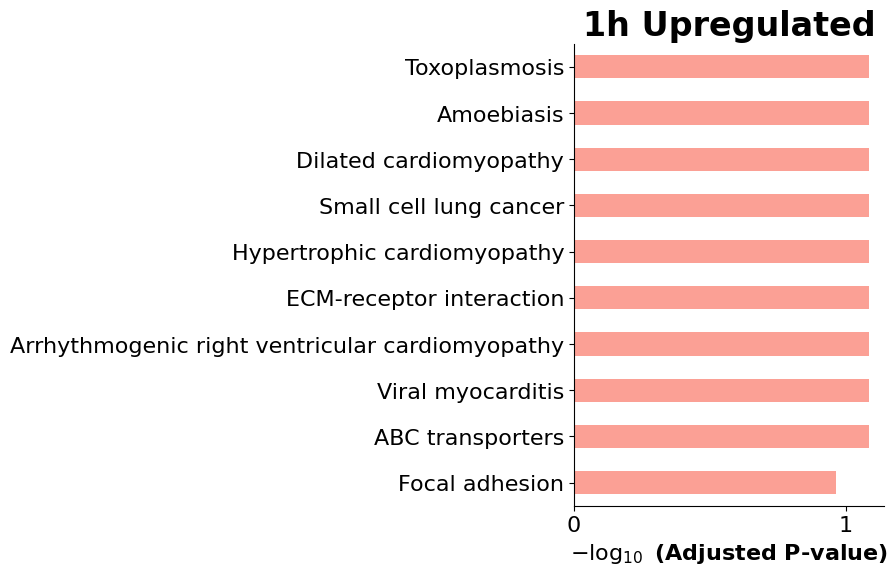

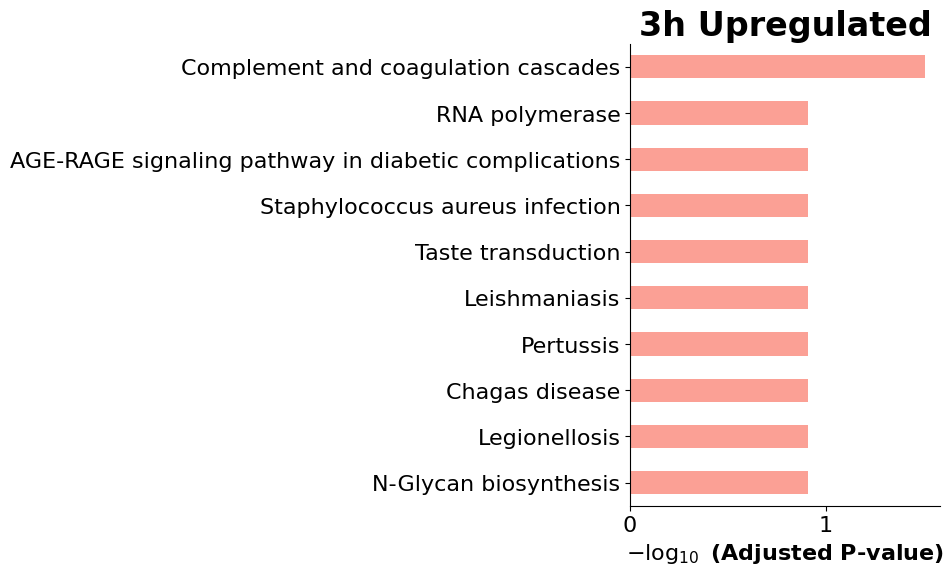

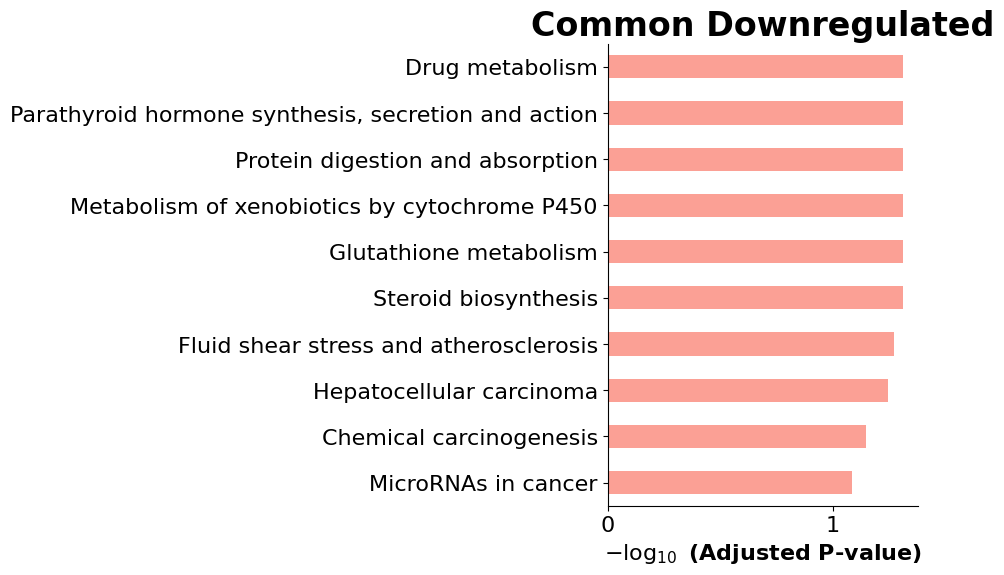

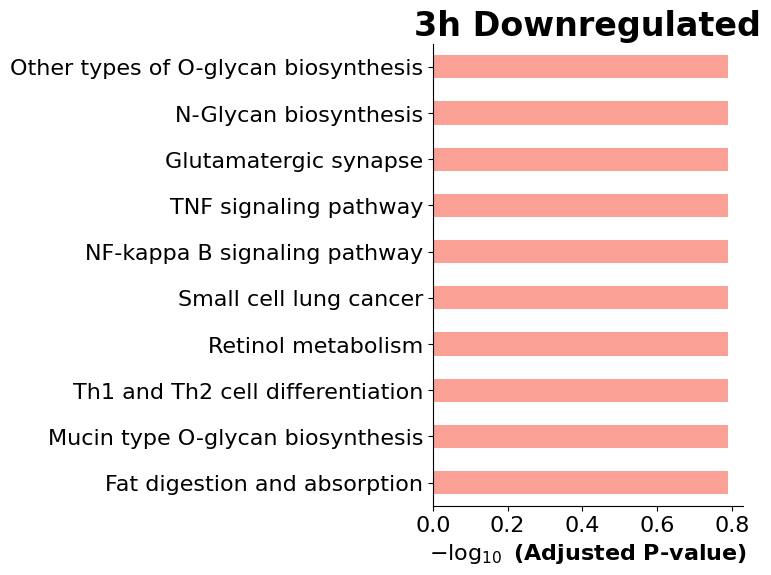

In [37]:
gp.barplot(enr1.results, title="1h Upregulated", cutoff=0.2)
gp.barplot(enr2.results, title="3h Upregulated", cutoff=0.2)
gp.barplot(enr3.results, title="Shared Downregulated", cutoff=0.2)
gp.barplot(enr4.results, title="3h Downregulated", cutoff=0.2)